# This code analyzes the birefringence images and their fits to get a torque

In [123]:
from skimage.color import gray2rgb
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

micron_per_pixel = 220 / 724.001 # micron / pixel

default_path = "C:\\Users\\Sumita\\Documents\\Research\\Microspheres\\birefringent measurements\\sphere images\\"
folder_name = '21-3-19_glass40X'
# folder_name = '18-4-19_german_8um_40X'

## First we import all the images and their fits, as well as the locations of the spheres
This was all done with other notebooks

In [124]:
path_name = default_path + folder_name + "\\"

npzfile_im_stack = np.load(path_name + 'aligned_image_stack.npz')
# npzfile_im_stack = np.load(path_name + 'image_stack.npz')
image_stack = npzfile_im_stack['image_stack']
n, nj, nk = image_stack.shape

radians = npzfile_im_stack['radians']

In [125]:
npzfile_fit_data = np.load(path_name + 'aligned_simple_intensity_sinusoid_amplitudes.npz')

amplitudear = npzfile_fit_data['amplitudes']
constant_ar = npzfile_fit_data['constant']
phase_array = npzfile_fit_data['phase']

circularity_squared = 1 - constant_ar ** 2

In [126]:
npzfile_s_bg_loc = np.load(path_name + 'sphere_locations.npz')
sphere_locations = npzfile_s_bg_loc['spheres']
backgroundcoords = npzfile_s_bg_loc['background']

sphere_circularity_squared = circularity_squared[sphere_locations]
background_circularity_squared = circularity_squared[backgroundcoords]

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

In [197]:
mean_sphere = np.average(sphere_circularity_squared)
mean_background = np.average(background_circularity_squared)

sigma_sphere = np.sqrt(np.average((sphere_circularity_squared - mean_sphere) ** 2))
sigma_background = np.sqrt(np.average((background_circularity_squared - mean_background) ** 2))

print mean_sphere, sigma_sphere
print mean_background, sigma_background

-0.014542823088 0.0912687317463
-0.00726188100066 0.0565693448818


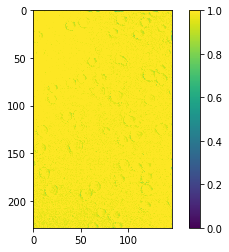

In [6]:
plt.figure()
# plt.title('coefficient of sinusoid in fit')
plt.imshow(np.abs(constant_ar.transpose()), extent=[0,nj * micron_per_pixel,nk * micron_per_pixel,0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

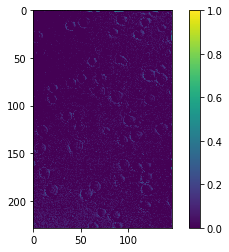

In [7]:
plt.figure()
# plt.title('Circularity squared ($1 - c^2$)')
plt.imshow(circularity_squared.transpose(), extent=[0,nj * micron_per_pixel,nk * micron_per_pixel,0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

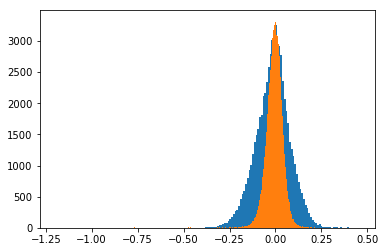

In [25]:
num_sp_bins = 100
num_bg_bins = 1500

plt.figure()
plt.hist(sphere_circularity_squared, bins=num_sp_bins)
plt.hist(background_circularity_squared, bins=num_bg_bins)
plt.show()

In [26]:
spy, spbins = np.histogram(sphere_circularity_squared, bins=num_sp_bins)
bgy, bgbins = np.histogram(background_circularity_squared, bins=num_bg_bins)

spx = spbins[1:]
bgx = bgbins[1:]

sp_popt, pcov = curve_fit(gauss, spx, spy)
sp_mu2 = sp_popt[0]

bg_popt, pcov = curve_fit(gauss, bgx, bgy)
bg_mu2 = bg_popt[0]

if bg_mu2 > 0:
    bg_mu = np.sqrt(bg_mu2)
else: 
    bg_mu = 0

if sp_mu2 > 0:
    sp_mu = np.sqrt(sp_mu2)
else: 
    sp_mu = 0

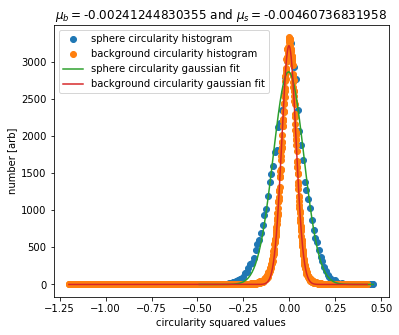

In [29]:
plt.figure(figsize=(6,5))

plt.plot(spx, spy, 'o', label='sphere circularity histogram')
plt.plot(bgx, bgy, 'o', label='background circularity histogram')
plt.plot(spx, gauss(spx, *sp_popt), label='sphere circularity gaussian fit')
plt.plot(bgx, gauss(bgx, *bg_popt), label='background circularity gaussian fit')

plt.xlabel('circularity squared values')
plt.ylabel('number [arb]')
plt.title('$\mu_b = $' + str(bg_popt[0]) + ' and $\mu_s = $' + str(sp_popt[0]))

plt.legend()
plt.show()

In [28]:
print bg_mu, sp_mu

0 0


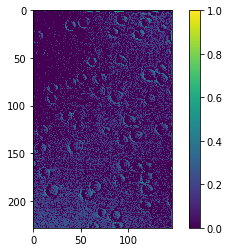

In [127]:
new_circ = circularity_squared.copy()
new_circ[new_circ<0] = 0
new_circ = np.sqrt(new_circ)

plt.figure()
# plt.title('Circularity ($\sqrt{1 - c^2}$) \n with unphysical values set to 0')
plt.imshow(new_circ.transpose(), extent=[0,nj * micron_per_pixel,nk * micron_per_pixel,0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

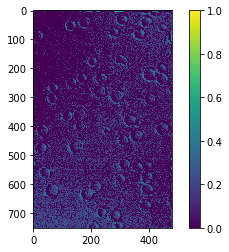

In [9]:
# %matplotlib notebook
plt.figure()
# plt.title('Circularity ($\sqrt{1 - c^2}$) \n with unphysical values set to 0')
plt.imshow(new_circ.transpose(), vmin=0, vmax=1)
plt.colorbar()
plt.show()

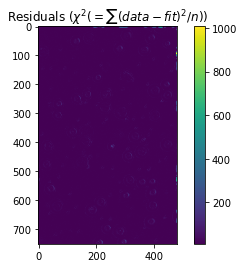

In [128]:
def sinusoid(angle, phase, amplitude, constant):
    return amplitude * (1. + constant * np.cos(2. * angle + phase))

theta = np.append(radians, radians + np.pi)

idata = np.append(image_stack, image_stack, axis=0)
imfit = np.zeros(idata.shape)
residual_ar = np.zeros((nj, nk))

for j in range(nj):
    for k in range(nk):
        data = idata[:, j, k]
        a = amplitudear[j, k]
        p = phase_array[j, k]
        c = constant_ar[j, k]

        fit = sinusoid(theta, p, a, c)
        imfit[:, j, k] = fit
        
        # Now going to calculate error as chi-squared
        difference = data - fit
        residual_ar[j, k] = np.sum(difference ** 2) / len(theta)


plt.figure()
plt.title('Residuals ($\chi^2 (= \sum{(data - fit)^2} / n)$)')
plt.imshow(residual_ar.transpose())
plt.colorbar()
plt.show()

In [129]:
def plot_fit(j, k):
    data = idata[:, j, k]
    a = amplitudear[j, k]
    p = phase_array[j, k]
    c = constant_ar[j, k]

    fit = sinusoid(theta, p, a, c)

    plt.figure()
    plt.plot(theta, data, 'o')
    plt.plot(theta, fit)
    plt.xlabel('Angle of top polarizer (radians)')
    plt.ylabel('Intensity measured')
    plt.title('$\chi^2=$'+str(residual_ar[j,k]) + ' for point $(j, k)$ = (' + str(j) + ', ' + str(k) + ')')
    plt.show()

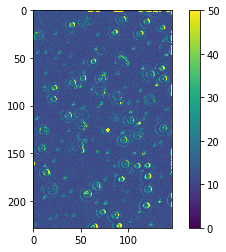

In [17]:
plt.figure()
# plt.title('Residuals ($\chi^2 (= \sum{(data - fit)^2 / \sigma^2})$)')
plt.imshow(residual_ar.transpose(), extent=[0,nj * micron_per_pixel,nk * micron_per_pixel,0], vmin=0, vmax=50)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


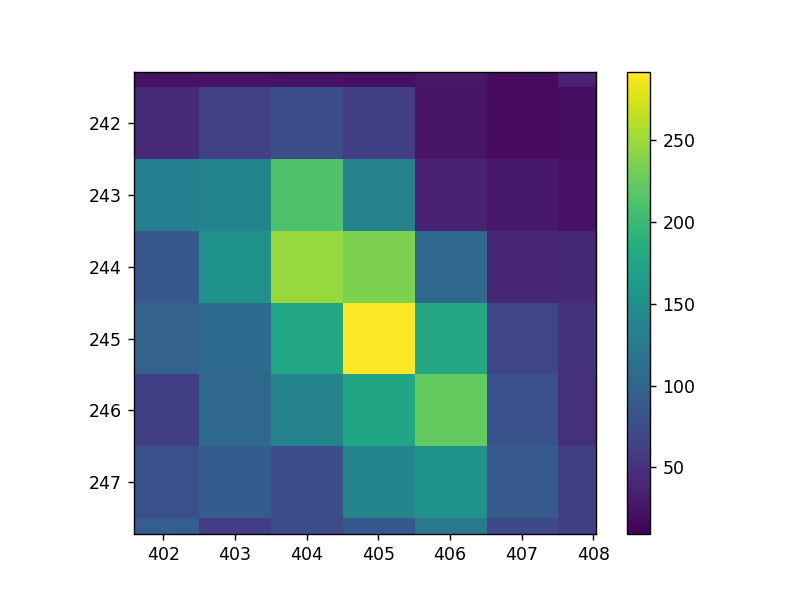

In [131]:
%matplotlib notebook

plt.figure()
plt.imshow(residual_ar[10:-10, 10:-10])
plt.colorbar()
plt.show()

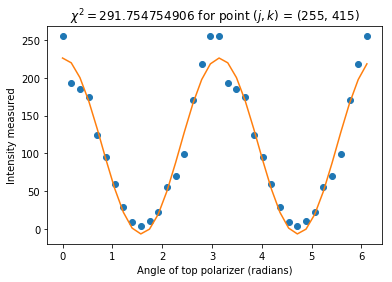

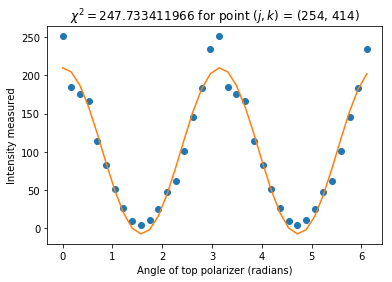

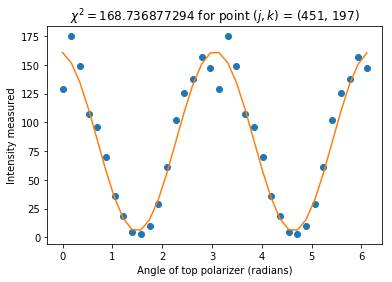

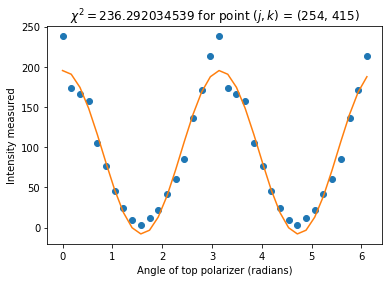

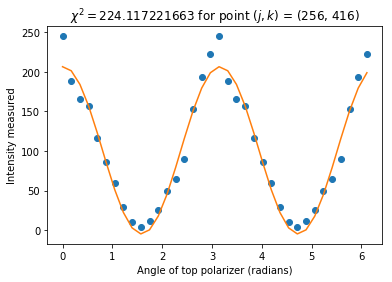

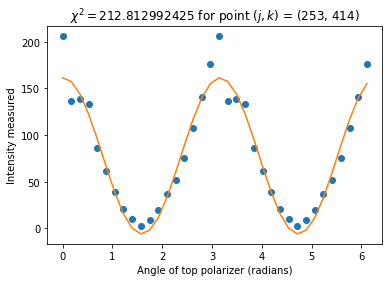

In [132]:
%matplotlib inline

plot_fit(255, 415)
plot_fit(254, 414)
plot_fit(451, 197)
plot_fit(254, 415)
plot_fit(256, 416)
plot_fit(253, 414)

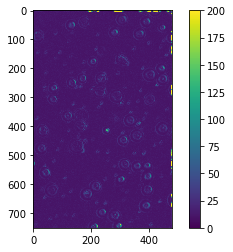

In [14]:
plt.figure()
# plt.title('Residuals ($\chi^2 (= \sum{(data - fit)^2 / \sigma^2})$)')
plt.imshow(residual_ar.transpose(), vmin=0, vmax=200)
plt.colorbar()
plt.show()

# Now for diameter and roundness histograms

In [28]:
from diameters_and_roundnesses import *

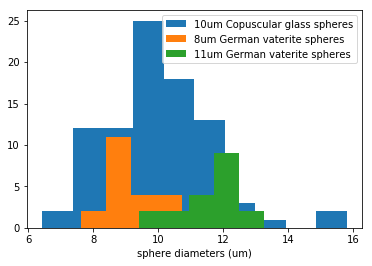

In [184]:
plt.figure()
plt.hist(c_g_10um_diameter, bins=10, label='10um Copuscular glass spheres')
plt.hist(g_v_8um_diameter, bins=5, label='8um German vaterite spheres')
plt.hist(g_v_11um_diameter, bins=5, label='11um German vaterite spheres')
plt.xlabel('sphere diameters (um)')
plt.legend()
plt.show()

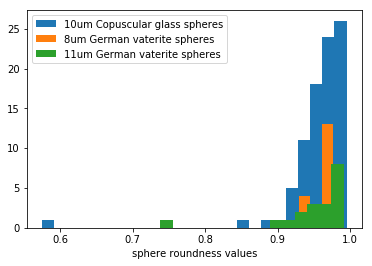

In [185]:
plt.figure()
plt.hist(c_g_10um_roundness, bins=25, label='10um Copuscular glass spheres')
plt.hist(g_v_8um_roundness, bins=4, label='8um German vaterite spheres')
plt.hist(g_v_11um_roundness, bins=15, label='11um German vaterite spheres')
plt.xlabel('sphere roundness values')
plt.legend()
plt.show()

In [47]:
def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

In [186]:
cg10_d_y, cg10_d_bins = np.histogram(c_g_10um_diameter, bins=10)
cg10_r_y, cg10_r_bins = np.histogram(c_g_10um_roundness, bins=25)
gv08_d_y, gv08_d_bins = np.histogram(g_v_8um_diameter, bins=5)
gv08_r_y, gv08_r_bins = np.histogram(g_v_8um_roundness, bins=4)
gv11_d_y, gv11_d_bins = np.histogram(g_v_11um_diameter, bins=5)
gv11_r_y, gv11_r_bins = np.histogram(g_v_11um_roundness, bins=15)

cg10_d_x = cg10_d_bins[1:]
cg10_r_x = cg10_r_bins[1:]
gv08_d_x = gv08_d_bins[1:]
gv08_r_x = gv08_r_bins[1:]
gv11_d_x = gv11_d_bins[1:]
gv11_r_x = gv11_r_bins[1:]

In [187]:
cg10_d_popt, pcov = curve_fit(gauss, cg10_d_x, cg10_d_y)
cg10_d_mu = cg10_d_popt[0]
gv08_d_popt, pcov = curve_fit(gauss, gv08_d_x, gv08_d_y, bounds=[[6, 0, 0], [12, 16, 16]])
gv08_d_mu = gv08_d_popt[0]
gv11_d_popt, pcov = curve_fit(gauss, gv11_d_x, gv11_d_y, bounds=[[8, 0, 0], [14, 16, 16]])
gv11_d_mu = gv11_d_popt[0]

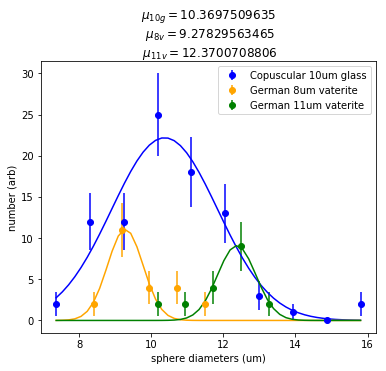

In [188]:
total_xs = np.append(np.append(cg10_d_x, gv08_d_x), gv11_d_x)
x_pts = np.linspace(np.min(total_xs), np.max(total_xs))

plt.figure(figsize=(6,5))

plt.errorbar(cg10_d_x, cg10_d_y, fmt='bo', yerr=np.sqrt(cg10_d_y), label='Copuscular 10um glass')
plt.plot(x_pts, gauss(x_pts, *cg10_d_popt), 'b-')

plt.errorbar(gv08_d_x, gv08_d_y, fmt='o', yerr=np.sqrt(gv08_d_y), color='orange', label='German 8um vaterite')
plt.plot(x_pts, gauss(x_pts, *gv08_d_popt), color='orange')

plt.errorbar(gv11_d_x, gv11_d_y, fmt='go', yerr=np.sqrt(gv11_d_y), label='German 11um vaterite')
plt.plot(x_pts, gauss(x_pts, *gv11_d_popt), 'g-')

plt.xlabel('sphere diameters (um)')
plt.ylabel('number (arb)')

plt.title('$\mu_{10g}=$'+str(cg10_d_mu) + '\n $\mu_{8v}=$'+str(gv08_d_mu) + '\n $\mu_{11v}=$'+str(gv11_d_mu))

plt.legend()
plt.show()

# same script show the edges on the circles overlayed on image

In [194]:
cg10_r_popt, pcov = curve_fit(gauss, cg10_r_x, cg10_r_y)
cg10_r_mu = cg10_r_popt[0]
gv08_r_popt, pcov = curve_fit(gauss, gv08_r_x, gv08_r_y, bounds=[0, [1.5, 1, 15]])
gv08_r_mu = gv08_r_popt[0]
gv11_r_popt, pcov = curve_fit(gauss, gv11_r_x, gv11_r_y, bounds=[0, [1., 1, 20]])
gv11_r_mu = gv11_r_popt[0]

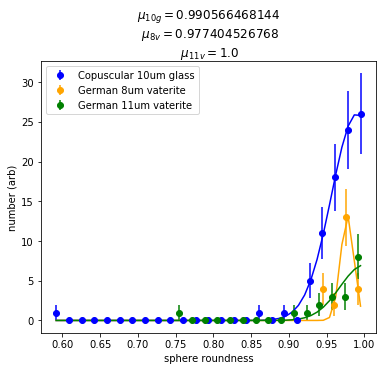

In [195]:
total_xs = np.append(np.append(cg10_r_x, gv08_r_x), gv11_r_x)
x_pts = np.linspace(np.min(total_xs), np.max(total_xs))

plt.figure(figsize=(6,5))

plt.errorbar(cg10_r_x, cg10_r_y, fmt='bo', yerr=np.sqrt(cg10_r_y), label='Copuscular 10um glass')
plt.plot(x_pts, gauss(x_pts, *cg10_r_popt), 'b-')

plt.errorbar(gv08_r_x, gv08_r_y, fmt='o', yerr=np.sqrt(gv08_r_y), color='orange', label='German 8um vaterite')
plt.plot(x_pts, gauss(x_pts, *gv08_r_popt), color='orange')

plt.errorbar(gv11_r_x, gv11_r_y, fmt='go', yerr=np.sqrt(gv11_r_y), label='German 11um vaterite')
plt.plot(x_pts, gauss(x_pts, *gv11_r_popt), 'g-')

plt.xlabel('sphere roundness')
plt.ylabel('number (arb)')

plt.title('$\mu_{10g}=$'+str(cg10_r_mu) + '\n $\mu_{8v}=$'+str(gv08_r_mu) + '\n $\mu_{11v}=$'+str(gv11_r_mu))

plt.legend()
plt.show()

# same script show the edges on the circles overlayed on image

In [196]:
print cg10_r_popt[1], gv08_r_popt[1], gv11_r_popt[1]

-0.0340089189092 0.00880925987051 0.0321133034038


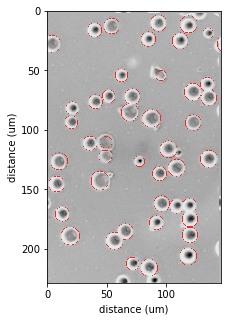

In [172]:
from skimage.feature import canny
edges = canny(sphere_locations.astype(float)).transpose()
im = gray2rgb(image_stack[0].transpose())
im[edges] = (10, 220, 220)

plt.figure(figsize=(10,5))
plt.imshow(im, extent=[0, nj * micron_per_pixel, nk * micron_per_pixel, 0])
plt.xlabel('distance (um)')
plt.ylabel('distance (um)')
plt.show()

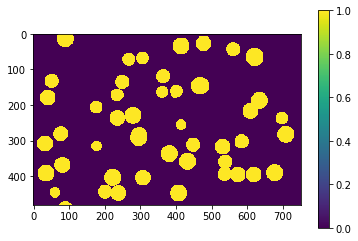

In [164]:
plt.imshow(sphere_locations)
plt.colorbar()
plt.show()

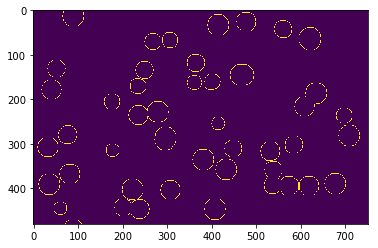

In [170]:
edges = canny(sphere_locations.astype(float))
plt.imshow(edges)
plt.show()